# Metric 1: Availibility of transit routes
For the analysis of the best Pittsburgh neighborhood by most accessible transportation, one of the datasets we chose to analyze was the availability of public transit routes.

In [1]:
import pandas as pd
import geopandas
import numpy as np

Above, I imported the necessary libraries need for my data analysis.

<AxesSubplot: >

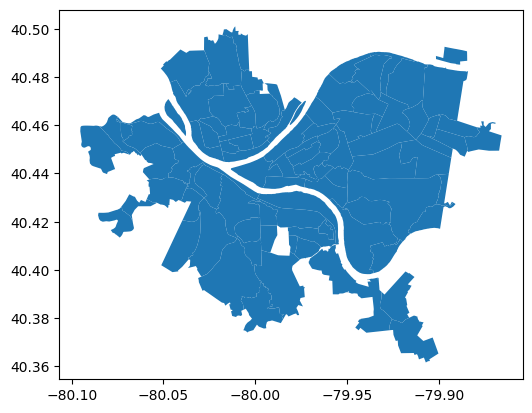

In [2]:
neighborhoods_map = geopandas.read_file('Neighborhoods_.shp')
neighborhoods_map.plot()

Above, I created a map of Pittsburgh neighborhoods that will be filled in with data about transit routes in the steps that follow.

<AxesSubplot: >

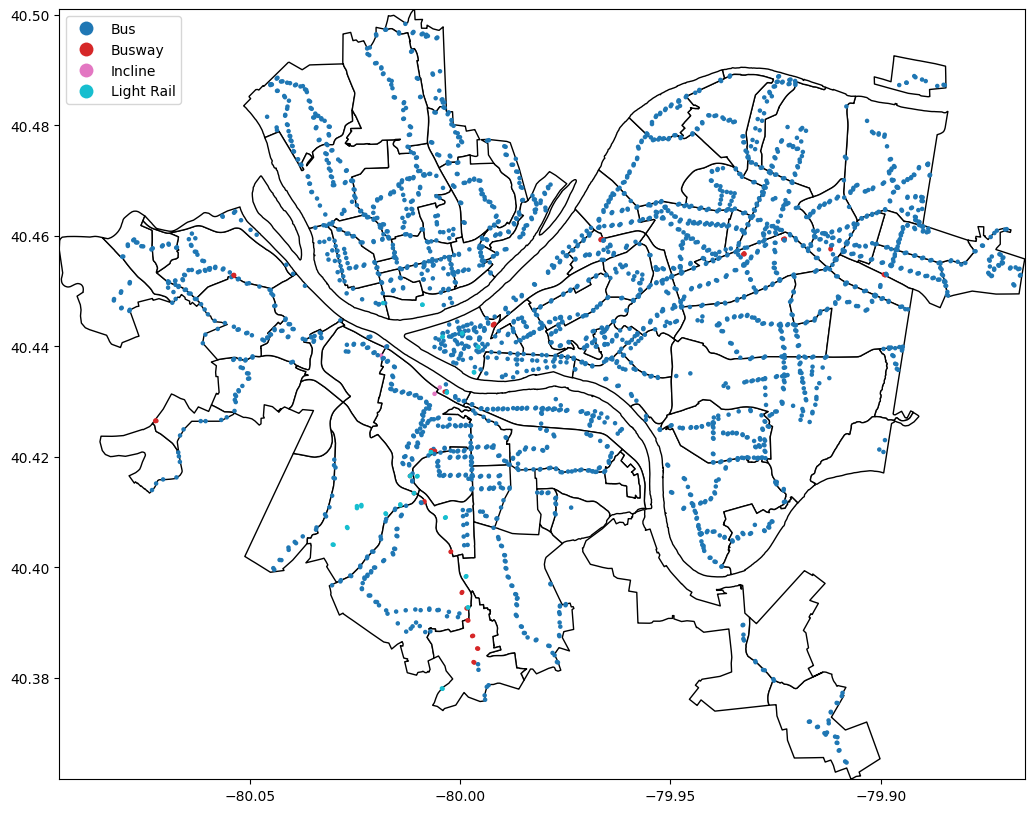

In [3]:
transit_stops = geopandas.read_file('PAAC_Stops_1909.shp')
transit_stops = transit_stops.to_crs(neighborhoods_map.crs)

mask = [True in result.values for result in [neighborhoods_map.contains(point) for point in transit_stops['geometry']]]
points_in_a_pgh_neighborhood = transit_stops.loc[mask]

base = neighborhoods_map.plot(color='white', edgecolor='black', figsize=(15,10))
minx = min(neighborhoods_map.bounds['minx'])
miny = min(neighborhoods_map.bounds['miny'])
maxx = max(neighborhoods_map.bounds['maxx'])
maxy = max(neighborhoods_map.bounds['maxy'])
base.set_xlim(minx, maxx)
base.set_ylim(miny, maxy)
points_in_a_pgh_neighborhood.plot(ax=base, markersize=5, column='Mode', legend=True)

In the above code, I wanted to look into a visual representation of transit stops that were in Pittsburgh neighborhoods specifically. So, using the neighborhoods map as a subplot and masking the transit data to only include points in a neighborhood, I created the above representation.
Once I created that representation, I wanted to figure out the percentage of stops in each neighborhood, which I create a visualization of below.

,objectid,hood,percent_total_stops
41,1334,Central Business District,3.526619
64,1357,Mount Washington,3.255341
22,1315,Lincoln-Lemington-Belmar,3.221431
24,1317,Bloomfield,3.187521
31,1324,Shadyside,3.051882
50,1343,Squirrel Hill South,2.746694
44,1337,Squirrel Hill North,2.644964
4,1297,Perry South,2.644964
49,1342,Greenfield,2.577145
79,1372,Brookline,2.407596


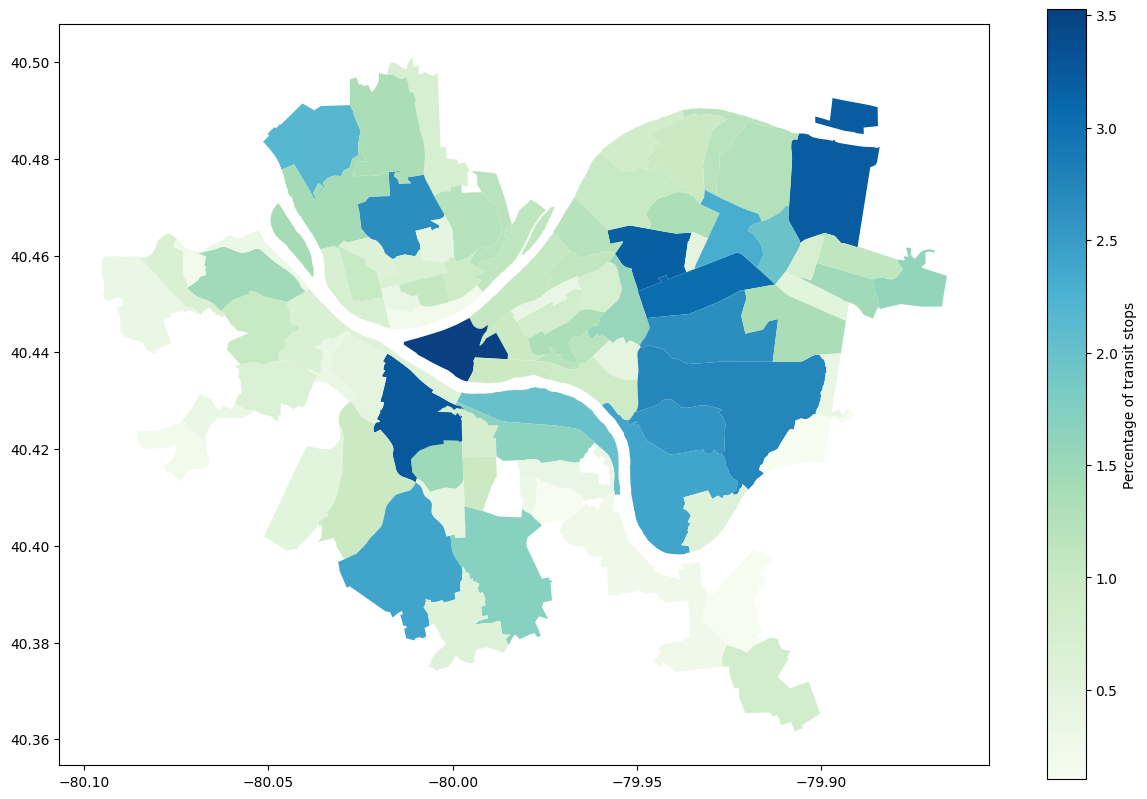

In [4]:
data = {}

for shape, objectid in zip(neighborhoods_map['geometry'], neighborhoods_map['objectid']):
	for point in points_in_a_pgh_neighborhood['geometry']:
		if shape.contains(point):
			if objectid in data:
				data[objectid] += 1
			else:
				data[objectid] = 1	

total_stops = sum(list(data.values()))

for key in data.keys(): # convert to percentages
	data[key] = (data[key] / total_stops) * 100

df_details = {
	'objectid': list(data.keys()),
	'percent_total_stops': list(data.values())
}
df = pd.DataFrame(df_details)
merged_df = neighborhoods_map.merge(df, how='left', left_on='objectid', right_on='objectid')
merged_df.plot(column='percent_total_stops', legend=True, figsize=(15,10), cmap='GnBu', legend_kwds= {'label': 'Percentage of transit stops'})
merged_df = merged_df.sort_values('percent_total_stops', ascending=False)
merged_df.head(10)[['objectid', 'hood', 'percent_total_stops']]

The above map illustrates the neighborhoods of Pittsburgh with the darker colored ones having more stops than the lighter colored ones. By printing out the top 10 values sorted by percentage, we also get the names of the neighborhoods with the most amount of stops.

,objectid,hood,num_routes
41,1334,Central Business District,84.0
82,1375,South Shore,30.0
31,1324,Shadyside,27.0
28,1321,Larimer,24.0
48,1341,South Oakland,21.0
37,1330,North Oakland,20.0
56,1349,Polish Hill,19.0
36,1329,Central Oakland,19.0
38,1331,West Oakland,18.0
12,1305,North Shore,18.0


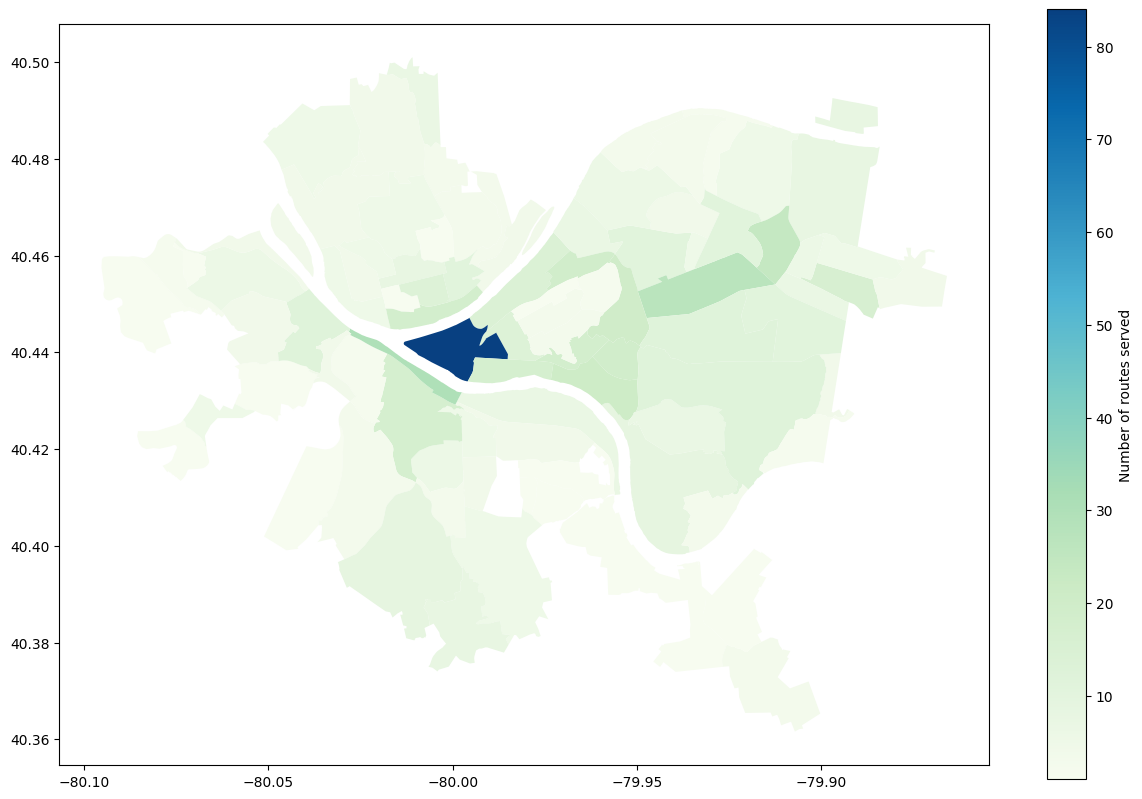

In [5]:
neighborhoods_routes_served = {}

for shape, objectid in zip(neighborhoods_map['geometry'], neighborhoods_map['objectid']):
	for point, routes_served in zip(points_in_a_pgh_neighborhood['geometry'], points_in_a_pgh_neighborhood['Routes_ser']):
		if shape.contains(point):
			if objectid in neighborhoods_routes_served:
				neighborhoods_routes_served[objectid] = neighborhoods_routes_served[objectid].union(set(routes_served.replace(' ', '').split(',')))
			else:
				neighborhoods_routes_served[objectid] = set(routes_served.replace(' ', '').split(','))

num_routes_by_neighborhood = {}
for objectid, routes in neighborhoods_routes_served.items():
	num_routes_by_neighborhood[objectid] = len(routes)

df_details_num_routes = {
	'objectid': list(num_routes_by_neighborhood.keys()),
	'num_routes': list(num_routes_by_neighborhood.values())
}

df_num_routes = pd.DataFrame(df_details_num_routes)

merged_df_num_routes = neighborhoods_map.merge(df_num_routes, how='left', left_on='objectid', right_on='objectid')
merged_df_num_routes.plot(column='num_routes', legend=True, figsize=(15,10), cmap='GnBu', legend_kwds= {'label': 'Number of routes served'})
merged_df_num_routes = merged_df_num_routes.sort_values('num_routes', ascending=False)
merged_df_num_routes.head(10)[['objectid', 'hood', 'num_routes']]

After examining the number of stops by neighborhood, my next thought was the fact that just because a neighborhood has a lot of transit stops, does not mean that it's accessible to other parts of the city because what if a large number of transit stops take up one route? So, I chose to examine the amount of routes served in a neighborhood as part of my analysis. As shown above, we can see the amount of routes served by neighborhood

,objectid,hood,num_routes
82,1375,South Shore,30.0
31,1324,Shadyside,27.0
28,1321,Larimer,24.0
48,1341,South Oakland,21.0
37,1330,North Oakland,20.0
56,1349,Polish Hill,19.0
36,1329,Central Oakland,19.0
38,1331,West Oakland,18.0
12,1305,North Shore,18.0
64,1357,Mount Washington,17.0


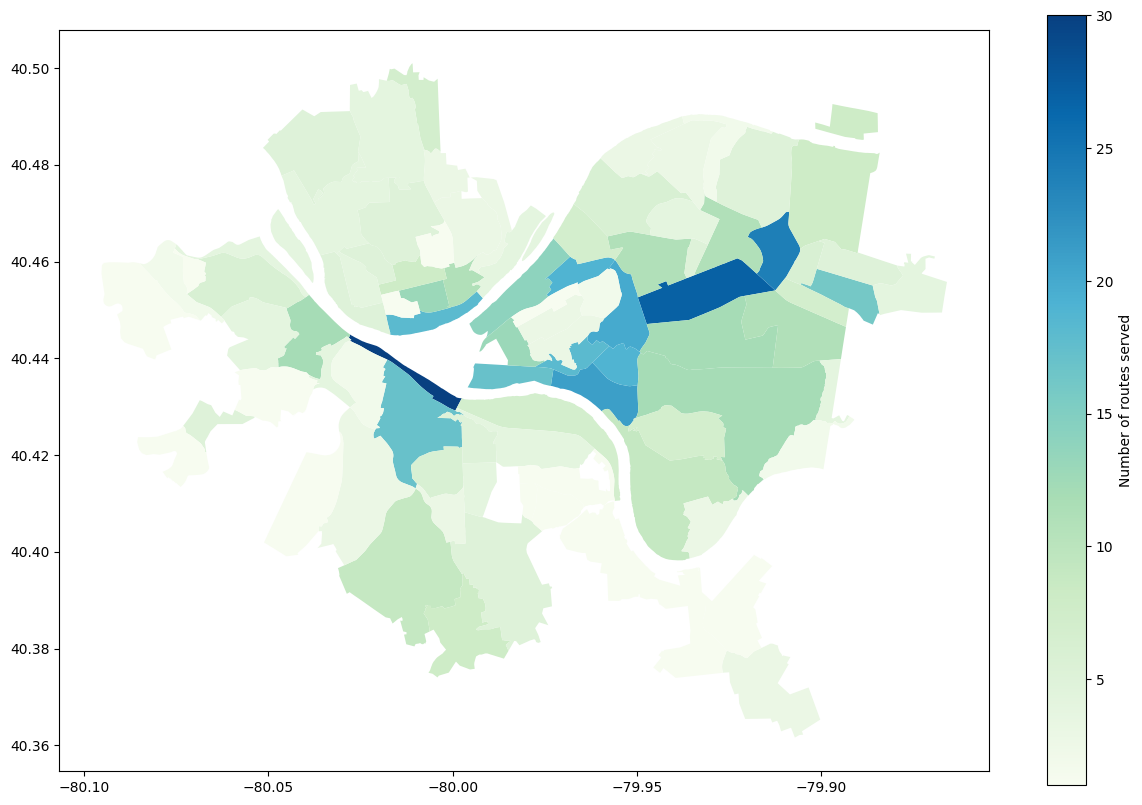

In [6]:
merged_df_num_routes_no_outlier = merged_df_num_routes[merged_df_num_routes.objectid != 1334]
merged_df_num_routes_no_outlier.plot(column='num_routes', legend=True, figsize=(15,10), cmap='GnBu', legend_kwds= {'label': 'Number of routes served'})
merged_df_num_routes_no_outlier.sort_values('num_routes', ascending=False)[['objectid', 'hood', 'num_routes']].head(10)

After noticing the outlier in the Central Business District, I wanted to create a second visualization in order to better represent the number of routes served per neighborhood. Finally, below I created bar graphs of the information represented by the above heat maps.

<AxesSubplot: ylabel='hood'>

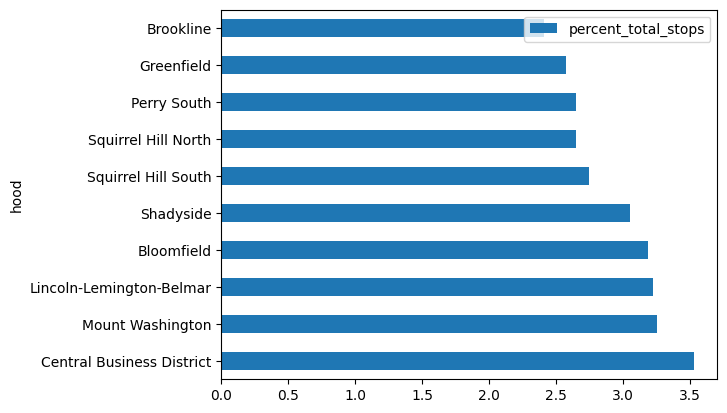

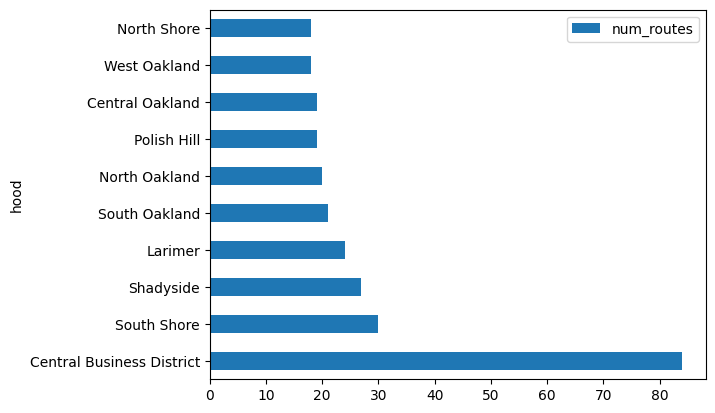

In [7]:
merged_df.head(10).plot.barh(x='hood', y='percent_total_stops')
merged_df_num_routes.head(10).plot.barh(x='hood', y='num_routes')

# Personal Conclusion
Out of the data that I extracted from the various datasets, it is clear that from the sheer amount of stops and number of routes served in a neighborhood that the Central Business District is the leading Pittsburgh neighborhood for accessible transportation